In [8]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [9]:
def make_system( alpha, beta, gamma, delta, epsilon, theta, zeta, eta, mu, nu, tau, l, kappa, xi, rho,
sigma):
    """Make A system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=385600, I=2410, D=0, A=0, R=0, T=0, H=0, E=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 28  # 28 more weeks

    return System(init=init, t0=t0, t_end=t_end,alpha = alpha,beta = beta,gamma = gamma,delta = delta,epsilon = epsilon,theta = theta,zeta = zeta,eta = eta,mu = mu,nu = nu,tau = tau,l = l,kappa = kappa,xi = xi,rho = rho,sigma = sigma)

In [10]:
tc = 9      # time between contacts in days, it can be 9 days already 
tr = 10      # recovery time in days
#transmission_rate
alpha,beta,gamma,delta = .4,.3,.2,.1
#rate of detection
epsilon,theta = .2,.7
## incubation rate
zeta,eta = 1/3, 1/7
# life threatening incubation
mu,nu = 1/14,1/7
# mortality rate
tau = .02
# rate of recovery
l,kappa,xi,rho,sigma = .8,.5,.5,.4,.3
# beta = 1 / tc      # contact rate in per day
# gamma = 1 / tr     # recovery rate in per day
system = make_system(alpha, beta, gamma, delta, epsilon, theta, zeta, eta, mu, nu, tau, l, kappa, xi, rho, sigma)

,values
init,S 0.993789 I 0.006211 D 0.000000 A ...
t0,0
t_end,196
alpha,0.4
beta,0.3
gamma,0.2
delta,0.1
epsilon,0.2
theta,0.7
zeta,0.333333


In [193]:
def update_func(state, T, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    T: time step
    system: System with beta and gamma
    
    returns: State object
    """
    constants  = ["alpha", "beta", "gamma", "delta", "epsilon", "theta", "zeta", "eta", "mu", "nu", "tau", "l", "kappa", "xi", "rho", "sigma"]
    (alpha, beta, gamma, delta, epsilon, theta, zeta, eta, mu, nu, tau, l, kappa, xi, rho, sigma) = [system[key] for key in constants]
    S,I,D,A,R,T,H,E = state

    infected = S*(alpha*I+beta*D+gamma*A*delta*R) - (epsilon + zeta+l )*I
    diagnosed = epsilon*I-(eta+rho)*D
    ailing = zeta*I-(theta+mu+kappa)*A
    recognized = eta*D+theta*A-(nu+xi)*R
    threatened = mu*A*nu*R-(sigma+tau)*T
    healed = l*I+rho*D+kappa*A+xi*R+sigma*T
    extinct = tau*T
    
    S -= infected
    I += infected
    D += diagnosed
    A += ailing 
    R += recognized 
    T += threatened 
    H += healed
    E += extinct
    return State(S=S,I=I,D=D,A=A,R=R,T=T,H=H,E=E)

In [14]:
init = State(S=385600, I=2410, D=0, A=0, R=0, T=0, H=0, E=0)
init /= sum(init)

state = update_func(init, 0, system)

,values
S,0.999601
I,0.000399
D,0.001242
A,0.002070
R,0.700000
T,0.000000
H,0.004969
E,0.000000


In [25]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add three Series objects to the System: S, I, R
    
    system: System object
    update_func: function that updates state
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init

    state = system.init
    t0 = system.t0
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [231]:
tc = 9      # time between contacts in days, it can be 9 days already 
tr = 10      # recovery time in days
#transmission_rate * contacts per day
alpha = .03*3
beta = .005*2
gamma = .005*3
delta = .005*3
#rate of detection
epsilon = .02/7
theta = .1*1/7
## incubation rate
zeta = .1/7 
eta = .1/7
# life threatening incubation
mu=1/7*.02
nu=.05/7
# mortality rate
tau = .02
# rate of recovery
l,kappa,xi,rho,sigma = np.array([.3,.25,.2,.2,.05])*.05*1/14
# beta = 1 / tc      # contact rate in per day
# gamma = 1 / tr     # recovery rate in per day
system = make_system(alpha, beta, gamma, delta, epsilon, theta, zeta, eta, mu, nu, tau, l, kappa, xi, rho, sigma)
results = run_simulation(system, update_func)
results.head()

,S,I,D,A,R,T,H,E
0,0.993789,0.006211,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
1,0.993346,0.006654,0.000018,0.000089,0.000000,0.000000e+00,0.000007,0.000000e+00
2,0.992873,0.007127,0.000036,0.000182,0.000002,0.000000e+00,0.000014,0.000000e+00
3,0.992365,0.007635,0.000056,0.000281,0.000005,5.655469e-15,0.000022,0.000000e+00
4,0.991822,0.008178,0.000077,0.000385,0.000009,3.208361e-14,0.000030,1.131094e-16


In [232]:
def plot_results(S, I, D, A, R, T, H,E):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, label = "infected")
    plot(D, label = "diagnosed")
    plot(A, label = "ailing")
    plot(R, label = "recognized")
    plot(T, label = "threatened")
    plot(H, label = "healed")
    plot(E, label = "extinct")
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

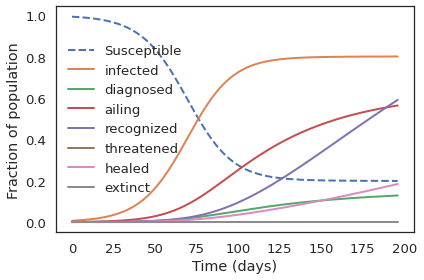

In [233]:
plot_results(results.S, results.I, results.D, results.A, results.R, results.T, results.H,results.E)
# savefig('C:/SJSU/EE104/EE104F20/Module 9 - Modeling/SIR-Fig01.pdf')